# **Titanic-Survival-Predictor**
----

## Necessary Modules

### Brings in all the tools for ML: preprocessing, pipelines, feature engineering, clustering, PCA, mutual info, and XGBoost.
### Seaborn + matplotlib for quick plots.

In [4]:
!pip install -q xgboost category_encoders joblib shap

In [5]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from category_encoders import TargetEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import (StratifiedKFold, RandomizedSearchCV,
                                     cross_validate)
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif


## ***Load Data***

In [7]:
TRAIN_PATH = "train.csv"   # adjust if needed
TEST_PATH  = "test.csv"


print("TRAIN:", TRAIN_PATH)
print("TEST :", TEST_PATH)


TRAIN: train.csv
TEST : test.csv


In [8]:
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

print("train shape:", train.shape)
print("test  shape:", test.shape)
display(train.head(6))
display(test.head(4))


train shape: (891, 12)
test  shape: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S


## ***Missing Values and Target distribution***

In [10]:
def missing_summary(df):
    miss = df.isnull().sum() / len(df) * 100
    return miss[miss > 0].sort_values(ascending=False)

print("Train missing (%):")
display(missing_summary(train))
print("Test missing (%):")
display(missing_summary(test))

print("\nTarget distribution (train):")
display(train['Survived'].value_counts(normalize=True).rename("proportion"))


Train missing (%):


Cabin       77.104377
Age         19.865320
Embarked     0.224467
dtype: float64

Test missing (%):


Cabin    78.229665
Age      20.574163
Fare      0.239234
dtype: float64


Target distribution (train):


Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

## ***Light EDA plots(Age,Fare distributions)***

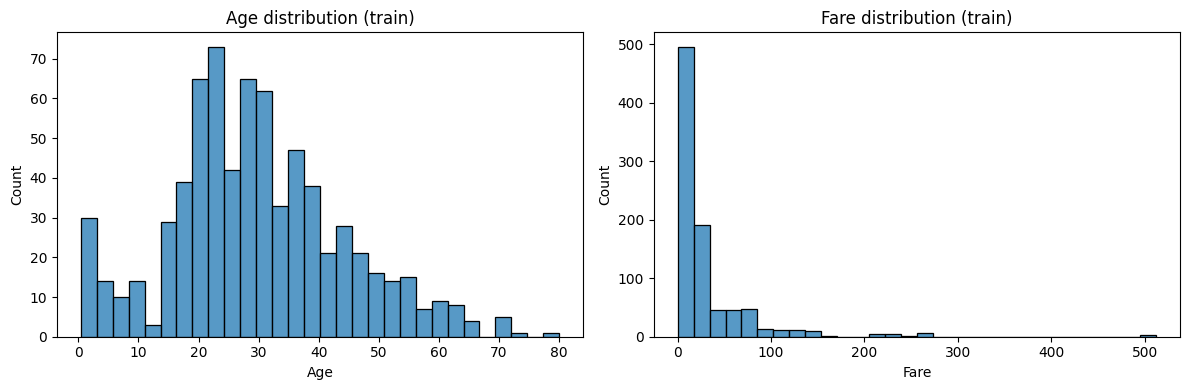

In [12]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(train['Age'].dropna(), bins=30, kde=False)
plt.title("Age distribution (train)")

plt.subplot(1,2,2)
sns.histplot(train['Fare'].dropna(), bins=30, kde=False)
plt.title("Fare distribution (train)")
plt.tight_layout()
plt.show()


## ***Feature engineering helper functions***

#### These helper functions used to derive titles, decks, ticket prefixes, and fare-per-person.

In [15]:
import re
def extract_title(name: str) -> str:
    if pd.isnull(name):
        return "Unknown"
    m = re.search(r",\s*([^\.]*)\.", name)
    return m.group(1).strip() if m else "Unknown"

def title_mapper(title: str) -> str:
    t = str(title).lower()
    if t == "mr": return "Mr"
    if t in ["mrs","mme"]: return "Mrs"
    if t in ["miss","ms","mlle"]: return "Miss"
    if t == "master": return "Master"
    if "dr" in t: return "Dr"
    if t in ["rev","col","major","capt","sir","jonkheer","don","countess","lady"]:
        return "Noble_Officer"
    return "Other"

def extract_deck(cabin: str) -> str:
    if pd.isnull(cabin): return np.nan
    return cabin.strip()[0]

def ticket_prefix(ticket: str) -> str:
    if pd.isnull(ticket): return "NONE"
    ticket_clean = ticket.replace(".", "").replace("/", "").strip()
    parts = ticket_clean.split()
    if len(parts) == 1:
        return "NUM"
    prefix = "".join([p for p in parts[:-1] if not p.isdigit()])
    return prefix.upper() if prefix else "NUM"

def fare_per_person(fare, family_size):
    try:
        if pd.isnull(fare) or family_size <= 0:
            return np.nan
        return fare / family_size
    except:
        return np.nan


## ***FeatureEngineer and KmeansClusterer(Transformers)***

#### These transformer classes: FeatureEngineer to add features and KMeansClusterer to add cluster labels.

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        # Titles
        X['Title'] = X['Name'].apply(extract_title).fillna("Unknown")
        X['Title'] = X['Title'].apply(title_mapper)
        # Family
        X['FamilySize'] = X['SibSp'] + X['Parch'] + 1
        X['IsAlone'] = (X['FamilySize'] == 1).astype(int)
        # Name / Surname / NameLength
        X['NameLength'] = X['Name'].apply(lambda s: len(s) if pd.notnull(s) else 0)
        X['Surname'] = X['Name'].apply(lambda s: s.split(',')[0].strip() if pd.notnull(s) else 'Unknown')
        # Ticket
        X['TicketPrefix'] = X['Ticket'].apply(ticket_prefix)
        # Cabin deck & flag
        X['CabinDeck'] = X['Cabin'].apply(extract_deck)
        X['HasCabin'] = X['Cabin'].notnull().astype(int)
        # Fare Per Person
        X['FarePerPerson'] = X.apply(lambda r: fare_per_person(r['Fare'], r['FamilySize']), axis=1)
        # Age groups & child flag
        X['IsChild'] = (X['Age'] < 16).astype(int)
        X['AgeGroup'] = pd.cut(X['Age'], bins=[-1,12,18,35,60,200], labels=['Child','Teen','YoungAdult','Adult','Senior'])
        # Class*Fare interaction
        X['ClassFare'] = X['Pclass'].astype(str) + '_' + pd.qcut(X['Fare'].fillna(X['Fare'].median()), q=4, labels=False).astype(str)
        return X

class KMeansClusterer(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=4, cols=None, random_state=42):
        self.n_clusters = n_clusters
        self.cols = cols
        self.random_state = random_state
        self.km = None
    def fit(self, X, y=None):
        if self.cols is None:
            raise ValueError("Please set cols for KMeansClusterer.")
        data = X[self.cols].fillna(X[self.cols].median())
        self.km = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        self.km.fit(data)
        return self
    def transform(self, X):
        X = X.copy()
        X[self.cols] = X[self.cols].fillna(X[self.cols].median())
        X[f'kmeans_{self.n_clusters}_clusters'] = self.km.predict(X[self.cols])
        return X


## ***Combine train + test , apply feature engineering ,split back***

#### *To perform the same feature engineering on both datasets for consistency, then split back into train_fe and test_fe. Note test_fe has no Survived.*

In [21]:
# Keep PassengerId for submission later
train_ids = train['PassengerId'].copy()
test_ids  = test['PassengerId'].copy()

train['is_train'] = 1
test['is_train'] = 0
combined = pd.concat([train, test], sort=False).reset_index(drop=True)

fe = FeatureEngineer()
combined_fe = fe.transform(combined)

# split back
train_fe = combined_fe[combined_fe['is_train'] == 1].drop(columns=['is_train'])
test_fe  = combined_fe[combined_fe['is_train'] == 0].drop(columns=['is_train','Survived'], errors='ignore')

print("train_fe shape:", train_fe.shape)
print("test_fe  shape:", test_fe.shape)
display(train_fe.head(3))


train_fe shape: (891, 24)
test_fe  shape: (418, 23)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,IsAlone,NameLength,Surname,TicketPrefix,CabinDeck,HasCabin,FarePerPerson,IsChild,AgeGroup,ClassFare
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,23,Braund,A5,NaN,0,3.62500,0,YoungAdult,3_0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,51,Cumings,PC,C,1,35.64165,0,Adult,1_3
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,1,22,Heikkinen,STONO2,NaN,0,7.92500,0,YoungAdult,3_1


## ***Fill obvious missing values (Fare median) and prepare candidate feature lists***

#### *The initial features for modeling. You’ll adjust later as MI and importance show results.*

In [24]:
# fill Fare in both if necessary
fare_median = train_fe['Fare'].median()
train_fe['Fare'] = train_fe['Fare'].fillna(fare_median)
test_fe['Fare']  = test_fe['Fare'].fillna(fare_median)

features_num = ['Age','Fare','FamilySize','FarePerPerson','NameLength']
features_cat = ['Pclass','Sex','Embarked','Title','CabinDeck','TicketPrefix','Surname','ClassFare','AgeGroup']
# ensure features exist
features_num = [c for c in features_num if c in train_fe.columns]
features_cat = [c for c in features_cat if c in train_fe.columns]

print("Numeric:", features_num)
print("Categorical:", features_cat)


Numeric: ['Age', 'Fare', 'FamilySize', 'FarePerPerson', 'NameLength']
Categorical: ['Pclass', 'Sex', 'Embarked', 'Title', 'CabinDeck', 'TicketPrefix', 'Surname', 'ClassFare', 'AgeGroup']


## ***Mutual Information ranking (quick filter)***

#### ****Mutual Information*** helps highlight which features are likely useful. Use it to refine all_features.*

In [27]:
def mutual_information_ranking(X, y, features):
    Xsub = X[features].copy()
    # ordinal-encode categorical temporarily for MI
    cat_cols = Xsub.select_dtypes(include=['object','category']).columns.tolist()
    if cat_cols:
        enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        Xsub[cat_cols] = enc.fit_transform(Xsub[cat_cols].fillna('NA'))
    Xsub = Xsub.fillna(-999)
    mi = mutual_info_classif(Xsub, y, random_state=42)
    return pd.Series(mi, index=features).sort_values(ascending=False)

cand_features = features_num + ['Sex','Pclass','Embarked','Title']
mi_scores = mutual_information_ranking(train_fe, train_fe['Survived'], cand_features)
print("Top MI scores:")
display(mi_scores.head(20))


Top MI scores:


Title            0.187773
FarePerPerson    0.147529
Sex              0.147177
Fare             0.127791
Pclass           0.066582
NameLength       0.057724
FamilySize       0.027930
Age              0.026652
Embarked         0.025923
dtype: float64

## ***KMeans clustering (fit on train, apply to both)***

#### *These creates cluster labels learned from training data and applied to test. Adds kmeans_4_clusters.*

In [30]:
kcols = ['Age','Fare','FamilySize']
kcols = [c for c in kcols if c in train_fe.columns]
km = KMeansClusterer(n_clusters=4, cols=kcols)
km.fit(train_fe)
train_fe = km.transform(train_fe)
test_fe  = km.transform(test_fe)

display(train_fe['kmeans_4_clusters'].value_counts())


kmeans_4_clusters
0    720
2    133
1     35
3      3
Name: count, dtype: int64

## ***PCA on numeric features (for inspection / plotting)***

#### ****Principal Component Analysis*** visualization helps see separability and variance explained.*

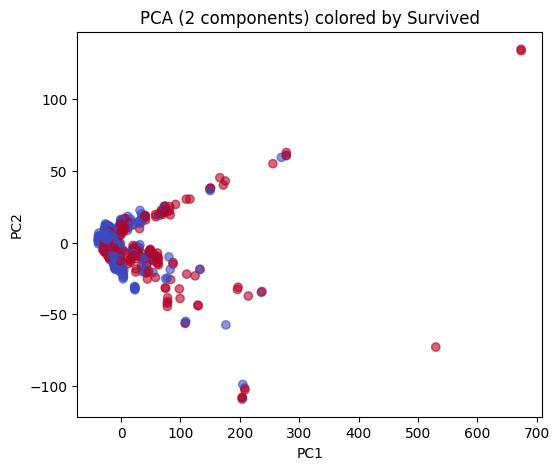

Explained variance: [0.87018171 0.06904807]


In [33]:
pca_cols = [c for c in ['Age','Fare','FamilySize','FarePerPerson','NameLength'] if c in train_fe.columns]
pca_df = train_fe[pca_cols].fillna(train_fe[pca_cols].median())
pca = PCA(n_components=2, random_state=42)
pca_res = pca.fit_transform(pca_df)

plt.figure(figsize=(6,5))
plt.scatter(pca_res[:,0], pca_res[:,1], c=train_fe['Survived'], cmap='coolwarm', alpha=0.6)
plt.title('PCA (2 components) colored by Survived')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.show()
print("Explained variance:", pca.explained_variance_ratio_)


## ***Safe target encoding (out-of-fold) for high-cardinality cols***

#### *This produces an ***out-of-fold*** target encodings for training rows (no leakage) and transforms test using a full-fit encoder. New columns named Surname_te, TicketPrefix_te appear.*

In [36]:
# We will OOF-target-encode Surname and TicketPrefix (example).
te_cols = [c for c in ['Surname','TicketPrefix'] if c in train_fe.columns]

if len(te_cols) > 0:
    if TargetEncoder is None:
        raise ImportError("category_encoders.TargetEncoder not available. Run `pip install category_encoders`.")
    def target_encode_oof(train_df, test_df, cols, target_col='Survived', n_splits=5):
        train_copy = train_df.copy()
        test_copy  = test_df.copy()
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        for col in cols:
            oof = pd.Series(index=train_copy.index, dtype=float)
            for train_idx, val_idx in skf.split(train_copy, train_copy[target_col]):
                te = TargetEncoder(cols=[col])
                te.fit(train_copy.loc[train_idx, [col]], train_copy.loc[train_idx, target_col])
                oof.iloc[val_idx] = te.transform(train_copy.loc[val_idx, [col]])[col].values
            # fill any remaining NaNs with global target mean
            oof = oof.fillna(train_copy[target_col].mean())
            # fit on full train and transform test
            full_te = TargetEncoder(cols=[col])
            full_te.fit(train_copy[[col]], train_copy[target_col])
            test_enc = full_te.transform(test_copy[[col]])[col].values
            train_copy[col + '_te'] = oof.values
            test_copy[col + '_te']  = test_enc
        return train_copy, test_copy

    print("Running OOF target-encoding for:", te_cols)
    train_fe, test_fe = target_encode_oof(train_fe, test_fe, te_cols, target_col='Survived', n_splits=5)
    # add new encoded columns to lists
    encoded_cols = [c + '_te' for c in te_cols]
    print("Added target-encoded cols:", encoded_cols)
else:
    encoded_cols = []


Running OOF target-encoding for: ['Surname', 'TicketPrefix']
Added target-encoded cols: ['Surname_te', 'TicketPrefix_te']


## ***Final feature selection for pipeline***

#### *To prepare lists for the ColumnTransformer.Target encoded columns are numeric.*

In [39]:
all_features = features_num + features_cat + ['kmeans_4_clusters'] + encoded_cols
# keep only columns that exist in train_fe
all_features = [c for c in all_features if c in train_fe.columns]
# split numeric vs categorical for preprocessor
numeric_features = [c for c in all_features if train_fe[c].dtype in [np.float64, np.int64] or c in encoded_cols]
categorical_features = [c for c in all_features if c not in numeric_features]

print("All features:", all_features)
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features[:15])


All features: ['Age', 'Fare', 'FamilySize', 'FarePerPerson', 'NameLength', 'Pclass', 'Sex', 'Embarked', 'Title', 'CabinDeck', 'TicketPrefix', 'Surname', 'ClassFare', 'AgeGroup', 'kmeans_4_clusters', 'Surname_te', 'TicketPrefix_te']
Numeric features: ['Age', 'Fare', 'FamilySize', 'FarePerPerson', 'NameLength', 'Pclass', 'Surname_te', 'TicketPrefix_te']
Categorical features: ['Sex', 'Embarked', 'Title', 'CabinDeck', 'TicketPrefix', 'Surname', 'ClassFare', 'AgeGroup', 'kmeans_4_clusters']


## ***Build preprocessing ColumnTransformer***

#### This ensures missing-value handling and scaling are part of the pipeline (prevents leakage).

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))

])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
], remainder='drop', sparse_threshold=0)


## ***Build model pipeline (XGBoost if available, else RandomForest)***

#### *It builds a single pipeline combining preprocessing + model for safe CV.*

In [45]:
import xgboost as xgb
if xgb is not None:
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
else:
    print("xgboost not found — using RandomForest as fallback")
    model = RandomForestClassifier(n_estimators=200, random_state=42)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])


## ***Cross-validated evaluation (stratified k-fold)***

#### *It checks baseline CV metrics. These are your cross-validated estimates.*

In [48]:
X_train = train_fe[all_features]
y_train = train_fe['Survived']
scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring, return_train_score=False)
print({k: np.mean(v) for k, v in scores.items()})


C:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:27:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:27:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:27:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:27:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

{'fit_time': 0.32500133514404295, 'score_time': 0.06139874458312988, 'test_accuracy': 0.831648986253217, 'test_f1': 0.7766061586617374, 'test_precision': 0.7913095064328461, 'test_recall': 0.7631713554987212, 'test_roc_auc': 0.8720883718102682}


## ***Light RandomizedSearchCV (tune a few params)***

#### *The tuner (keeps runtime reasonable). n_jobs=-1 uses all cores (change to 1 if your machine is limited).*

In [51]:
if xgb is not None:
    param_distributions = {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [3, 4, 6],
        'model__learning_rate': [0.01, 0.05, 0.1]
    }
else:
    param_distributions = {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [5, 10, 15]
    }

rs = RandomizedSearchCV(pipeline, param_distributions, n_iter=6, cv=StratifiedKFold(4, shuffle=True, random_state=42),
                        scoring='roc_auc', random_state=42, n_jobs=1, verbose=1)
rs.fit(X_train, y_train)

print("Best params:", rs.best_params_)
print("Best CV score (roc_auc):", rs.best_score_)
best_pipeline = rs.best_estimator_


Fitting 4 folds for each of 6 candidates, totalling 24 fits


C:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:27:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:27:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:27:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:27:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

Best params: {'model__n_estimators': 100, 'model__max_depth': 4, 'model__learning_rate': 0.1}
Best CV score (roc_auc): 0.8948369013492194


## ***Fit best pipeline on full train and save pipeline.***

#### *Final training on the whole training set and serialization of pipeline (preprocessing + model) for deployment.*

In [54]:
import os, re, warnings
OUTPUT_DIR = "titanic_pipeline_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)


print("OUTPUT:", OUTPUT_DIR)

OUTPUT: titanic_pipeline_outputs


In [55]:
import joblib
# Fit on full train
best_pipeline.fit(X_train, y_train)
joblib.dump(best_pipeline, os.path.join(OUTPUT_DIR, "titanic_best_pipeline.pkl"))
print("Saved pipeline to:", os.path.join(OUTPUT_DIR, "titanic_best_pipeline.pkl"))


C:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:27:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Saved pipeline to: titanic_pipeline_outputs\titanic_best_pipeline.pkl


## ***Predict on test and create submission***

#### *Produces a kaggle-ready (submission.csv)*

In [58]:
X_test = test_fe[all_features]
test_preds = best_pipeline.predict(X_test)
# If you want probabilities:
test_probs = best_pipeline.predict_proba(X_test)[:,1] if hasattr(best_pipeline, "predict_proba") else None

submission = pd.DataFrame({
    "PassengerId": test['PassengerId'],
    "Survived": test_preds.astype(int)
})
submission_path = os.path.join(OUTPUT_DIR, "submission.csv")
submission.to_csv(submission_path, index=False)
print("Saved submission to:", submission_path)


Saved submission to: titanic_pipeline_outputs\submission.csv


## ***Feature importances (best-effort)***

#### *To extracts importances for tree-based models and saves them. For complex pipelines the mapping of one-hot names sometimes fails — this is a best-effort approach.*

In [61]:
try:
    mdl = best_pipeline.named_steps['model']
    if hasattr(mdl, "feature_importances_"):
        # try to recover transformed feature names
        pre = best_pipeline.named_steps['preprocessor']
        num_names = numeric_features
        try:
            cat_encoder = pre.named_transformers_['cat'].named_steps['onehot']
            cat_names = list(cat_encoder.get_feature_names_out(categorical_features))
        except Exception:
            cat_names = categorical_features
        feature_names = num_names + cat_names
        importances = pd.Series(mdl.feature_importances_, index=feature_names).sort_values(ascending=False)
        display(importances.head(30))
        importances.to_csv(os.path.join(OUTPUT_DIR, "feature_importances.csv"))
        print("Saved feature importances.")
    else:
        print("Model has no feature_importances_.")
except Exception as e:
    print("Could not extract importances:", e)


Title_Mr               0.364182
Pclass                 0.076342
Title_Noble_Officer    0.071224
Surname_te             0.039290
Sex_female             0.031917
FamilySize             0.030128
CabinDeck_C            0.026929
FarePerPerson          0.025693
ClassFare_1_3          0.021516
Title_Master           0.020574
Embarked_S             0.019801
ClassFare_3_1          0.019161
TicketPrefix_STONO     0.018143
CabinDeck_B            0.016689
TicketPrefix_te        0.016387
AgeGroup_Adult         0.015974
Age                    0.015194
AgeGroup_YoungAdult    0.014795
kmeans_4_clusters_1    0.014585
Fare                   0.013895
Embarked_C             0.013855
NameLength             0.013218
ClassFare_3_2          0.012234
TicketPrefix_CA        0.011017
ClassFare_1_2          0.010419
CabinDeck_A            0.010241
Title_Miss             0.009863
ClassFare_2_2          0.009128
CabinDeck_E            0.007635
Title_Mrs              0.007523
dtype: float32

Saved feature importances.


## ***Optional: SHAP explainability (if SHAP + XGBoost installed)***

#### *Optional interpretability; SHAP plots can be heavy and require careful mapping of transformed feature names.*

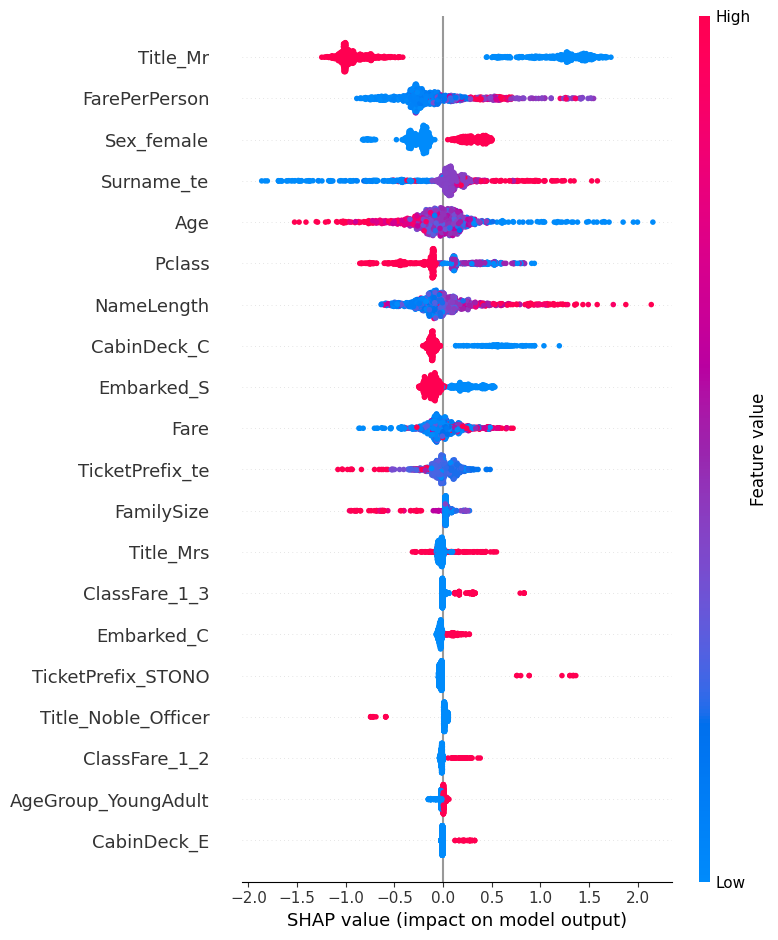

In [64]:
# Optional and can be heavy — run only if you installed shap and xgboost
if xgb is not None:
    try:
        import shap
        # get transformed train data
        transformed = best_pipeline.named_steps['preprocessor'].transform(X_train)
        # shap for xgboost expects DMatrix-like or model booster; shallow approach:
        explainer = shap.TreeExplainer(best_pipeline.named_steps['model'])
        shap_values = explainer.shap_values(transformed)
        shap.summary_plot(shap_values, transformed, feature_names=(numeric_features + list(best_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))))
    except Exception as e:
        print("SHAP step skipped or failed:", e)
else:
    print("XGBoost not available; skip SHAP.")


In [65]:
import joblib

# After training your pipeline/model
joblib.dump(pipeline, "model.pkl")


['model.pkl']

In [66]:
import streamlit as st
import joblib
import pandas as pd

# Load pipeline
pipeline = joblib.load("model.pkl")

st.title("🚀 Prediction App")

# Example input fields (change to match your dataset)
age = st.number_input("Age", min_value=0, max_value=120, value=25)
gender = st.selectbox("Gender", ["Male", "Female"])
income = st.number_input("Annual Income", min_value=0, value=50000)

# Convert input into dataframe
input_df = pd.DataFrame([{
    "age": age,
    "gender": gender,
    "income": income
}])

if st.button("Predict"):
    prediction = pipeline.predict(input_df)[0]
    st.success(f"✅ Prediction: {prediction}")


2025-09-02 12:27:22.079 
  command:

    streamlit run C:\ProgramData\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [ ]:
!streamlit run app_streamlit.py --server.headless true
